# Comparision between Various DCQAOA Settings

DCQAOA is a generalization of the QAOA algorithm that makes use of an additional Hamiltonian, called the Counterdiabatic Hamiltonian or CD Hamiltonian. The QAOA algorithm is, in some sense, a digitized version of quantum annealing, where the time parameters are replaced by parameters to be optimized over. Quantum annealing promises to reach the ground state of the problem Hamiltonian from the initial state, given that the evolution is performed very slowly. For QAOA, this translates to a large number of layers of repetition. To combat this slow driving, DCQAOA uses a counterdiabatic term to incorporate shortcuts to adiabaticity, which reduces the time to solution, or alternatively reduces the circuit depth or the number of layers of repetition. This ultimately leads to faster convergence to the optimal solution.

The CD Hamiltonian can take multiple forms. One such form is the commutator of the problem Hamiltonian and the mixer Hamiltonian. This makes the CD Hamiltonian dependent on the problem Hamiltonian. Alternatively, one can also choose a CD Hamiltonian that is problem Hamiltonian independent. To do this, one can choose the CD Hamiltonian $H_{CD} = \sum_i \alpha_i Y_i + \sum_{i,j} \beta_{i,j} X_iY_j + \sum_{i,j} \gamma_{i,j} Y_iZ_j$, for some values of $\alpha_i, \beta_{ij}$ and $\gamma_{ij}$. Note that some of these can also be $0$.

In this notebook, we investigate how different CD Hamiltonians affect the performance of DCQAOA for solving the MIS problem. For this, we consider the following $8$ CD Hamiltonians for simulations:
1. Commutator of the problem Hamiltonian and the mixer Hamiltonian
2. $H_{CD} = \sum_i Y_i$
3. $H_{CD} = \sum_{i,j} X_iY_j$
4. $H_{CD} = \sum_{i,j} Y_iZ_j$
5. $H_{CD} = \sum_i Y_i + \sum_{i,j} X_iY_j$
6. $H_{CD} = \sum_i Y_i + \sum_{i,j} Y_iZ_j$
7. $H_{CD} = \sum_{i,j} X_iY_j + \sum_{i,j} Y_iZ_j$
8. $H_{CD} = \sum_i Y_i + \sum_{i,j} X_iY_j + \sum_{i,j} Y_iZ_j$

For comparison, we compare the performance of DCQAOA with different CD Hamiltonian settings with the naive QAOA algorithm, for different numbers of layers of repetition.

### Importing required functions

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from qiskit import *
from qiskit.circuit.library import TwoLocal
from qiskit.quantum_info import SparsePauliOp

import rustworkx as rx
import numpy as np
from rustworkx.visualization import mpl_draw
import matplotlib.pyplot as plt

from src.graph_gen import *
from src.hamiltonian_gen import get_hamiltonian_from_graph
from src.helper_functions import top_k_counts

In [3]:
from src.bfminimize import BFMinimizeCombinatorial
from src.qaoa import QAOA
from src.dcqaoa import DCQAOA

#### Graph Generation and Brute Force Optimization

In [4]:
num_instances = 8
graph_instances = []
graph_hamiltonians = []

for i in range(num_instances):
    graph = generate_random_graph(6, 0.4)
    graph_instances.append(graph)
    cost_hamiltonian = get_hamiltonian_from_graph(graph)
    graph_hamiltonians.append(cost_hamiltonian)

In [5]:
brute_optimal_cost = []
for hamiltonian in graph_hamiltonians:
    brute = BFMinimizeCombinatorial(hamiltonian)
    brute.run()
    brute_optimal_cost.append(brute.optimal_value)

In [6]:
avg_brute_optimal_cost = sum(brute_optimal_cost)/num_instances

#### QAOA

In [7]:
max_repetitions = 6

In [8]:
qaoa_optimal_cost = []

for reps in range(max_repetitions):
    print(f"Solving for Reps {reps}...")
    qaoa_optimal_cost.append([])
    for idx, hamiltonian in enumerate(graph_hamiltonians):
        qaoa = QAOA(hamiltonian, num_layers = reps)
        qaoa.run()
        qaoa_optimal_cost[-1].append(qaoa.optimal_value)

Solving for Reps 0...
Solving for Reps 1...
Solving for Reps 2...
Solving for Reps 3...
Solving for Reps 4...
Solving for Reps 5...


In [9]:
avg_qaoa_optimal_cost = []
for optimal_cost_arr in qaoa_optimal_cost:
    avg_qaoa_optimal_cost.append(sum(optimal_cost_arr)/num_instances)

avg_qaoa_error = [np.abs(avg_brute_optimal_cost - q_opt) for q_opt in avg_qaoa_optimal_cost]

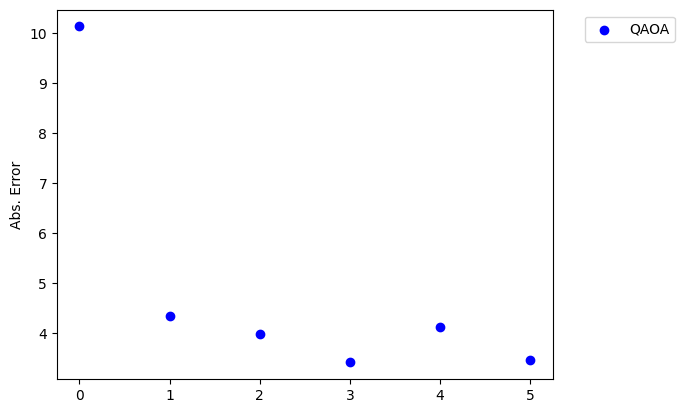

In [10]:
plt.scatter(range(max_repetitions), avg_qaoa_error, color = 'b', label = 'QAOA')

plt.ylabel("Max. Repetitions")
plt.ylabel("Abs. Error")

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

#### DC-QAOA\['Y'\]

In [11]:
dcqaoa_y_optimal_cost = []

for reps in range(max_repetitions):
    print(f"Solving for Reps {reps}...")
    dcqaoa_y_optimal_cost.append([])
    for idx, hamiltonian in enumerate(graph_hamiltonians):
        dcqaoa_y = DCQAOA( hamiltonian, num_layers = reps, cd_hamiltonian_type=['Y'])
        dcqaoa_y.run()
        dcqaoa_y_optimal_cost[-1].append(dcqaoa_y.optimal_value)

Solving for Reps 0...
Solving for Reps 1...
Solving for Reps 2...
Solving for Reps 3...
Solving for Reps 4...
Solving for Reps 5...


In [12]:
avg_dcqaoa_y_optimal_cost = []
for optimal_cost_arr in dcqaoa_y_optimal_cost:
    avg_dcqaoa_y_optimal_cost.append(sum(optimal_cost_arr)/num_instances)

avg_dcqaoa_y_error = [np.abs(avg_brute_optimal_cost - dc_opt) for dc_opt in avg_dcqaoa_y_optimal_cost]

#### DC-QAOA\['XY'\]

In [13]:
dcqaoa_xy_optimal_cost = []

for reps in range(max_repetitions):
    print(f"Solving for Reps {reps}...")
    dcqaoa_xy_optimal_cost.append([])
    for idx, hamiltonian in enumerate(graph_hamiltonians):
        dcqaoa_xy = DCQAOA( hamiltonian, num_layers = reps, cd_hamiltonian_type=['XY', 'YX'])
        dcqaoa_xy.run()
        dcqaoa_xy_optimal_cost[-1].append(dcqaoa_xy.optimal_value)

Solving for Reps 0...
Solving for Reps 1...
Solving for Reps 2...
Solving for Reps 3...
Solving for Reps 4...
Solving for Reps 5...


In [14]:
avg_dcqaoa_xy_optimal_cost = []
for optimal_cost_arr in dcqaoa_xy_optimal_cost:
    avg_dcqaoa_xy_optimal_cost.append(sum(optimal_cost_arr)/num_instances)

avg_dcqaoa_xy_error = [np.abs(avg_brute_optimal_cost - dc_opt) for dc_opt in avg_dcqaoa_xy_optimal_cost]

#### DC-QAOA\['YZ'\]

In [15]:
dcqaoa_yz_optimal_cost = []

for reps in range(max_repetitions):
    print(f"Solving for Reps {reps}...")
    dcqaoa_yz_optimal_cost.append([])
    for idx, hamiltonian in enumerate(graph_hamiltonians):
        dcqaoa_yz = DCQAOA( hamiltonian, num_layers = reps, cd_hamiltonian_type=['YZ', 'ZY'])
        dcqaoa_yz.run()
        dcqaoa_yz_optimal_cost[-1].append(dcqaoa_yz.optimal_value)

Solving for Reps 0...
Solving for Reps 1...
Solving for Reps 2...
Solving for Reps 3...
Solving for Reps 4...
Solving for Reps 5...


In [16]:
avg_dcqaoa_yz_optimal_cost = []
for optimal_cost_arr in dcqaoa_yz_optimal_cost:
    avg_dcqaoa_yz_optimal_cost.append(sum(optimal_cost_arr)/num_instances)

avg_dcqaoa_yz_error = [np.abs(avg_brute_optimal_cost - dc_opt) for dc_opt in avg_dcqaoa_yz_optimal_cost]

#### DC-QAOA\['Y', 'XY'\]

In [17]:
dcqaoa_y_xy_optimal_cost = []

for reps in range(max_repetitions):
    print(f"Solving for Reps {reps}...")
    dcqaoa_y_xy_optimal_cost.append([])
    for idx, hamiltonian in enumerate(graph_hamiltonians):
        dcqaoa_y_xy = DCQAOA( hamiltonian, num_layers = reps, cd_hamiltonian_type=['Y', 'XY', 'YX'])
        dcqaoa_y_xy.run()
        dcqaoa_y_xy_optimal_cost[-1].append(dcqaoa_y_xy.optimal_value)

Solving for Reps 0...
Solving for Reps 1...
Solving for Reps 2...
Solving for Reps 3...
Solving for Reps 4...
Solving for Reps 5...


In [18]:
avg_dcqaoa_y_xy_optimal_cost = []
for optimal_cost_arr in dcqaoa_y_xy_optimal_cost:
    avg_dcqaoa_y_xy_optimal_cost.append(sum(optimal_cost_arr)/num_instances)

avg_dcqaoa_y_xy_error = [np.abs(avg_brute_optimal_cost - dc_opt) for dc_opt in avg_dcqaoa_y_xy_optimal_cost]

#### DC-QAOA\['Y', 'YZ'\]

In [19]:
dcqaoa_y_yz_optimal_cost = []

for reps in range(max_repetitions):
    print(f"Solving for Reps {reps}...")
    dcqaoa_y_yz_optimal_cost.append([])
    for idx, hamiltonian in enumerate(graph_hamiltonians):
        dcqaoa_y_yz = DCQAOA( hamiltonian, num_layers = reps, cd_hamiltonian_type=['Y', 'YZ', 'ZY'])
        dcqaoa_y_yz.run()
        dcqaoa_y_yz_optimal_cost[-1].append(dcqaoa_y_yz.optimal_value)

Solving for Reps 0...
Solving for Reps 1...
Solving for Reps 2...
Solving for Reps 3...
Solving for Reps 4...
Solving for Reps 5...


In [20]:
avg_dcqaoa_y_yz_optimal_cost = []
for optimal_cost_arr in dcqaoa_y_yz_optimal_cost:
    avg_dcqaoa_y_yz_optimal_cost.append(sum(optimal_cost_arr)/num_instances)

avg_dcqaoa_y_yz_error = [np.abs(avg_brute_optimal_cost - dc_opt) for dc_opt in avg_dcqaoa_y_yz_optimal_cost]

#### DC-QAOA\['XY', 'YZ'\]

In [22]:
dcqaoa_xy_yz_optimal_cost = []

for reps in range(max_repetitions):
    print(f"Solving for Reps {reps}...")
    dcqaoa_xy_yz_optimal_cost.append([])
    for idx, hamiltonian in enumerate(graph_hamiltonians):
        dcqaoa_xy_yz = DCQAOA( hamiltonian, num_layers = reps, cd_hamiltonian_type=['XY', 'YX', 'YZ', 'ZY'])
        dcqaoa_xy_yz.run()
        dcqaoa_xy_yz_optimal_cost[-1].append(dcqaoa_xy_yz.optimal_value)

Solving for Reps 0...
Solving for Reps 1...
Solving for Reps 2...
Solving for Reps 3...
Solving for Reps 4...
Solving for Reps 5...


In [23]:
avg_dcqaoa_xy_yz_optimal_cost = []
for optimal_cost_arr in dcqaoa_xy_yz_optimal_cost:
    avg_dcqaoa_xy_yz_optimal_cost.append(sum(optimal_cost_arr)/num_instances)

avg_dcqaoa_xy_yz_error = [np.abs(avg_brute_optimal_cost - dc_opt) for dc_opt in avg_dcqaoa_xy_yz_optimal_cost]

#### DC-QAOA\['Y', 'XY', 'YZ'\]

In [24]:
dcqaoa_y_xy_yz_optimal_cost = []

for reps in range(max_repetitions):
    print(f"Solving for Reps {reps}...")
    dcqaoa_y_xy_yz_optimal_cost.append([])
    for idx, hamiltonian in enumerate(graph_hamiltonians):
        dcqaoa_y_xy_yz = DCQAOA( hamiltonian, num_layers = reps, cd_hamiltonian_type=['Y', 'XY', 'YX', 'YZ', 'ZY'])
        dcqaoa_y_xy_yz.run()
        dcqaoa_y_xy_yz_optimal_cost[-1].append(dcqaoa_y_xy_yz.optimal_value)

Solving for Reps 0...
Solving for Reps 1...
Solving for Reps 2...
Solving for Reps 3...
Solving for Reps 4...
Solving for Reps 5...


In [25]:
avg_dcqaoa_y_xy_yz_optimal_cost = []
for optimal_cost_arr in dcqaoa_y_xy_yz_optimal_cost:
    avg_dcqaoa_y_xy_yz_optimal_cost.append(sum(optimal_cost_arr)/num_instances)

avg_dcqaoa_y_xy_yz_error = [np.abs(avg_brute_optimal_cost - dc_opt) for dc_opt in avg_dcqaoa_y_xy_yz_optimal_cost]

#### DC-QAOA\[Commutator\]

In [26]:
dcqaoa_comm_optimal_cost = []

for reps in range(max_repetitions):
    print(f"Solving for Reps {reps}...")
    dcqaoa_comm_optimal_cost.append([])
    for idx, hamiltonian in enumerate(graph_hamiltonians):
        dcqaoa_comm = DCQAOA( hamiltonian, num_layers = reps, cd_hamiltonian_type='commutator')
        dcqaoa_comm.run()
        dcqaoa_comm_optimal_cost[-1].append(dcqaoa_comm.optimal_value)

Solving for Reps 0...
Solving for Reps 1...
Solving for Reps 2...
Solving for Reps 3...
Solving for Reps 4...
Solving for Reps 5...


In [27]:
avg_dcqaoa_comm_optimal_cost = []
for optimal_cost_arr in dcqaoa_comm_optimal_cost:
    avg_dcqaoa_comm_optimal_cost.append(sum(optimal_cost_arr)/num_instances)

avg_dcqaoa_comm_error = [np.abs(avg_brute_optimal_cost - dc_opt) for dc_opt in avg_dcqaoa_comm_optimal_cost]

### Plotting the results

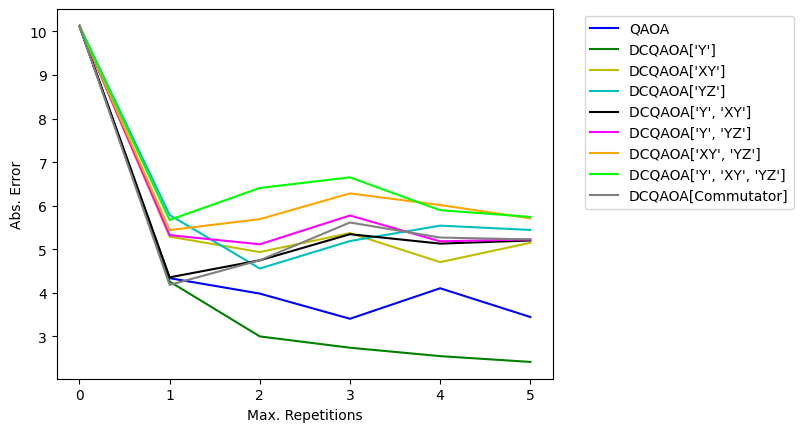

In [30]:
plt.plot(range(max_repetitions), avg_qaoa_error, color = 'b', label = "QAOA")
plt.plot(range(max_repetitions), avg_dcqaoa_y_error, color = 'g', label = "DCQAOA['Y']")
plt.plot(range(max_repetitions), avg_dcqaoa_xy_error, color = 'y', label = "DCQAOA['XY']")
plt.plot(range(max_repetitions), avg_dcqaoa_yz_error, color = 'c', label = "DCQAOA['YZ']")
plt.plot(range(max_repetitions), avg_dcqaoa_y_xy_error, color = 'k', label = "DCQAOA['Y', 'XY']")
plt.plot(range(max_repetitions), avg_dcqaoa_y_yz_error, color = 'magenta', label = "DCQAOA['Y', 'YZ']")
plt.plot(range(max_repetitions), avg_dcqaoa_xy_yz_error, color = 'orange', label = "DCQAOA['XY', 'YZ']")
plt.plot(range(max_repetitions), avg_dcqaoa_y_xy_yz_error, color = 'lime', label = "DCQAOA['Y', 'XY', 'YZ']")
plt.plot(range(max_repetitions), avg_dcqaoa_comm_error, color = 'grey', label = "DCQAOA[Commutator]")

plt.xlabel("Max. Repetitions")
plt.ylabel("Abs. Error")

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

We can infer from the plot that the only setting that performs better than QAOA is DCQAOA with only $Y$ terms in the CD Hamiltonian. This is quite interesting. Recall that the problem Hamiltonian for the MIS problem is of the form $\sum_i \alpha_i Z_i + \sum_{(i,j)\in E} \beta_{ij}Z_iZ_j$, which contains both individual $Z$ interactions and $ZZ$ interactions. So, one might be biased to think that including $XY$ and $YZ$ terms in the CD Hamiltonian could improve the performance of the algorithm. However, the evidence suggests otherwise. In fact, the only algorithm that performs better than QAOA contains only individual $Y$ terms in the CD Hamiltonian, without any two-qubit interaction terms.

So, DCQAOA with only $Y$ terms for the CD Hamiltonian is more suitable for the MIS problem than any other CD Hamiltonian setting or even QAOA. The reason behind the degradation of the performance when two-qubit interaction terms are included in the CD Hamiltonian is a good direction for a future investigation.